<h2><font face="SimSun" color="black">一、项目背景介绍</font></h2>

    吸烟有害健康。在公共场合吸烟更是会影响他人的正常生活，对他人造成困扰。所以为减少和消除烟草烟雾危害，保障公众健康，我们需要对公共场合进行吸烟检测，在体育、健身场馆的室外观众坐席、赛场区域、公共交通工具的室外等候区域等全面禁止吸烟。对于公共场合的吸烟问题，为此一种无人化、智能化吸烟检测装置的需求迫在眉睫。有了智能吸烟检测装置可以减少人力的控制，更好地营造良好的公共环境。

<h2><font face="SimSun" color="black">二、数据集的准备与介绍</font></h2>

数据集是采用[Niki_173](这个人也太优秀了吧~快来AI Studio看看~ https://aistudio.baidu.com/aistudio/personalcenter/thirdview/474269)的[吸烟、抽烟检测数据集](https://aistudio.baidu.com/aistudio/datasetdetail/94796)

还可以使用labelimg自己训练数据集![](https://ai-studio-static-online.cdn.bcebos.com/e535f0b0bd2249fd940959f3b468bfc091efebe6ab1d42238dc2939f1505533c)


1. 把数据集解压到work文件夹下

In [ ]:
!unzip -oq data/data94796/pp_smoke.zip -d work/

2. 查看数据集的目录结构

In [ ]:
!tree work/ -d

work/
├── Annotations
└── images

2 directories


3. 样本的可视化展示

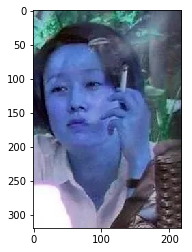

In [ ]:
# 样例：语义分割数据集抽样可视化
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(cv2.imread("work/images/smoke_a239.jpg"))

    计算该数据集的均值和方差

In [ ]:
# 计算图像数据整体均值和方差
import glob
import numpy as np


def get_mean_std(image_path_list):
    print('Total images:', len(image_path_list))
    max_val, min_val = np.zeros(3), np.ones(3) * 255
    mean, std = np.zeros(3), np.zeros(3)
    for image_path in image_path_list:
        image = cv2.imread(image_path)
        for c in range(3):
            mean[c] += image[:, :, c].mean()
            std[c] += image[:, :, c].std()
            max_val[c] = max(max_val[c], image[:, :, c].max())
            min_val[c] = min(min_val[c], image[:, :, c].min())

    mean /= len(image_path_list)
    std /= len(image_path_list)

    mean /= max_val - min_val
    std /= max_val - min_val

    return mean, std


mean, std = get_mean_std(glob.glob('work/images/smoke_a*.jpg'))
print('mean:', mean)
print('std:', std)

Total images: 783
mean: [0.37024683 0.40113492 0.45985683]
std: [0.20945029 0.21247627 0.22364787]


    数据集类的定义

In [ ]:
import paddle
import numpy as np
import paddle.vision.transforms as T


class MyImageNetDataset(paddle.io.Dataset):
    def __init__(self,
                 num_samples,
                 num_classes):
        super(MyImageNetDataset, self).__init__()

        self.num_samples = num_samples
        self.num_classes = num_classes
        self.transform = T.Compose([
            T.Resize(size=(224, 224)),
            T.ToTensor(),
            T.Normalize(mean=127.5, std=127.5)])

    def __getitem__(self, index):
        image = np.random.randint(low=0, high=256, size=(512, 512, 3))
        label = np.random.randint(low=0, high=self.num_classes, size=(1,))

        image = image.astype('float32')
        label = label.astype('int64')

        image = self.transform(image)

        return image, label

    def __len__(self):
        return self.num_samples

    数据集类的测试

In [ ]:
train_dataset = MyImageNetDataset(num_samples=1200, num_classes=1000)
print(len(train_dataset))

image, label = train_dataset[0]
print(image.shape, label.shape)


for image, label in train_dataset:
    print(image.shape, label.shape)
    break

1200
[3, 224, 224] (1,)
[3, 224, 224] (1,)


In [ ]:
train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    drop_last=False)

for step, data in enumerate(train_dataloader):
    image, label = data
    print(step, image.shape, label.shape)

0 [128, 3, 224, 224] [128, 1]
1 [128, 3, 224, 224] [128, 1]
2 [128, 3, 224, 224] [128, 1]
3 [128, 3, 224, 224] [128, 1]
4 [128, 3, 224, 224] [128, 1]
5 [128, 3, 224, 224] [128, 1]
6 [128, 3, 224, 224] [128, 1]
7 [128, 3, 224, 224] [128, 1]
8 [128, 3, 224, 224] [128, 1]
9 [48, 3, 224, 224] [48, 1]


* 按比例划分数据集

In [ ]:
import random
import os
#生成train.txt和val.txt
random.seed(2020)
xml_dir  = '/home/aistudio/work/Annotations'#标签文件地址
img_dir = '/home/aistudio/work/images'#图像文件地址
path_list = list()
for img in os.listdir(img_dir):
    img_path = os.path.join(img_dir,img)
    xml_path = os.path.join(xml_dir,img.replace('jpg', 'xml'))
    path_list.append((img_path, xml_path))
random.shuffle(path_list)
ratio = 0.9
train_f = open('/home/aistudio/work/train.txt','w') #生成训练文件
val_f = open('/home/aistudio/work/val.txt' ,'w')#生成验证文件

for i ,content in enumerate(path_list):
    img, xml = content
    text = img + ' ' + xml + '\n'
    if i < len(path_list) * ratio:
        train_f.write(text)
    else:
        val_f.write(text)
train_f.close()
val_f.close()

#生成标签文档
label = ['smoke']#设置你想检测的类别
with open('/home/aistudio/work/label_list.txt', 'w') as f:
    for text in label:
        f.write(text+'\n')

<h2><font face="SimSun" color="black">三、模型介绍</font></h2>

PaddleDetection飞桨目标检测开发套件，旨在帮助开发者更快更好地完成检测模型的组建、训练、优化及部署等全开发流程。
PaddleDetection模块化地实现了多种主流目标检测算法，提供了丰富的数据增强策略、网络模块组件（如骨干网络）、损失函数等，并集成了模型压缩和跨平台高性能部署能力。
经过长时间产业实践打磨，PaddleDetection已拥有顺畅、卓越的使用体验，被工业质检、遥感图像检测、无人巡检、新零售、互联网、科研等十多个行业的开发者广泛应用。

特性
* 模型丰富: 包含目标检测、实例分割、人脸检测等100+个预训练模型，涵盖多种全球竞赛冠军方案
* 使用简洁：模块化设计，解耦各个网络组件，开发者轻松搭建、试用各种检测模型及优化策略，快速得到高性能、定制化的算法。
* 端到端打通: 从数据增强、组网、训练、压缩、部署端到端打通，并完备支持云端/边缘端多架构、多设备部署。
* 高性能: 基于飞桨的高性能内核，模型训练速度及显存占用优势明显。支持FP16训练, 支持多机训练。
github地址：https://github.com/PaddlePaddle/PaddleDetection

<h2><font face="SimSun" color="black">四、模型训练</font></h2>

#配置PaddleDetection套件，为训练做准备

* 下载PaddleDetection

In [ ]:

#PaddleDetection的代码库下载，同时支持github源和gitee源，为了在国内网络环境更快下载，此处使用gitee源。  
#! git clone https://github.com/PaddlePaddle/PaddleDetection.git
! git clone https://gitee.com/paddlepaddle/PaddleDetection.git

fatal: destination path 'PaddleDetection' already exists and is not an empty directory.


* 通过如下方式安装PaddleDetection依赖，并设置环境变量

In [ ]:
!pip install -r /home/aistudio/PaddleDetection/requirements.txt

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.


In [2]:
%cd PaddleDetection
!pip install Cython
!pip install pycocotools
!pip install lap
!pip install motmetrics

/home/aistudio/PaddleDetection
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 106 kB 6.4 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=273789 sha256=9b53c7a6371f497e151680d6e3ed31f036cebef33b2d66d6d3bd785a7799e008
  Stored in directory: /home/aistudio/.cache/pip/wheels/c0/01/5f/670dfd20204fc9cc6bf843db4e014acb998f411922e3abc49f
Successfully built pycocotools
You should consider upgrading via the '/opt/conda/envs/python35-paddle120-env/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |██

#更改参数配置

我们使用configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_voc.yml配置进行训练。 
![](https://ai-studio-static-online.cdn.bcebos.com/2d46363833254cb38ee2801762b284a577805465f465480a97d6e15e77ea9f86)


需要修改的几个地方（画黄色的地方）
../datasets/voc.yml：![](https://ai-studio-static-online.cdn.bcebos.com/c60019747d7847a6a3dd461d3f9f3db04c36f21e2f764cbbae12b61d2223127e)


base/optimizer_270e.yml![](https://ai-studio-static-online.cdn.bcebos.com/da8f403f4e05447cb18daa57463dbd0adb2456d8473440e2b927a4bad63dd7d0)


#开始训练

In [7]:
!python tools/train.py -c configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_voc.yml --eval --use_vdl=True --vdl_log_dir="./output"

<h2><font face="SimSun" color="black">五、模型评估</font></h2>

In [4]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing paddledet.egg-info/PKG-INFO
writing dependency_links to paddledet.egg-info/dependency_links.txt
writing requirements to paddledet.egg-info/requires.txt
writing top-level names to paddledet.egg-info/top_level.txt
adding license file 'LICENSE' (matched pattern 'LICEN[CS]E*')
reading manifest file 'paddledet.egg-info/SOURCES.txt'
writing manifest file 'paddledet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying ppdet/version.py -> build/lib/ppdet
copying ppdet/utils/check.py -> build/lib/ppdet/utils
copying ppdet/model_zoo/MODEL_ZOO -> build/lib/ppdet/model_zoo
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/ppdet
copying build/lib/ppdet/version.py -> build/bdist.linux-x86_64/egg/ppdet
copying build/lib/ppdet/optimizer.py -> build/bdist.linux-x86_64/egg/ppdet
creating build/bdist.linux-x86_64/egg/ppdet/modeling
creating build/bdist

In [ ]:
!python -u tools/eval.py -c configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_voc.yml  -o weights=output/yolov3_mobilenet_v3_large_ssld_270e_voc/best_model.pdparams

W0219 20:39:22.578263  1070 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0219 20:39:22.583869  1070 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[02/19 20:39:26] ppdet.utils.checkpoint INFO: Finish loading model weights: output/yolov3_mobilenet_v3_large_ssld_270e_voc/best_model.pdparams
[02/19 20:39:26] ppdet.engine INFO: Eval iter: 0
[02/19 20:39:28] ppdet.metrics.metrics INFO: Accumulating evaluatation results...
[02/19 20:39:28] ppdet.metrics.metrics INFO: mAP(0.50, 11point) = 85.85%
[02/19 20:39:28] ppdet.engine INFO: Total sample number: 78, averge FPS: 33.189564648572116


1. 导出模型

In [8]:
!python tools/export_model.py -c configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_voc.yml  -o weights=output/yolov3_mobilenet_v3_large_ssld_270e_voc/best_model.pdparams

[02/21 20:16:35] ppdet.utils.checkpoint INFO: Finish loading model weights: output/yolov3_mobilenet_v3_large_ssld_270e_voc/best_model.pdparams
[02/21 20:16:35] ppdet.engine INFO: Export inference config file to output_inference/yolov3_mobilenet_v3_large_ssld_270e_voc/infer_cfg.yml
W0221 20:16:38.470975  2901 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0221 20:16:38.471014  2901 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[02/21 20:16:43] ppdet.engine INFO: Export model and saved in output_inference/yolov3_mobilenet_v3_large_ssld_270e_voc


2. 可视化模型效果

* 图片分析结果

In [14]:
!python tools/infer.py -c configs/yolov3/yolov3_mobilenet_v3_large_ssld_270e_voc.yml -o weights=output/yolov3_mobilenet_v3_large_ssld_270e_voc/best_model.pdparams --infer_img=/home/aistudio/work/xiyan1.jpg

W0221 20:59:35.478997 11443 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0221 20:59:35.483273 11443 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[02/21 20:59:39] ppdet.utils.checkpoint INFO: Finish loading model weights: output/yolov3_mobilenet_v3_large_ssld_270e_voc/best_model.pdparams
[02/21 20:59:40] ppdet.engine INFO: Detection bbox results save in output/xiyan1.jpg


![](https://ai-studio-static-online.cdn.bcebos.com/68c6af9923cc42bbaf45bfe4e8c82fc3b746d9a10572445bb2d992e81c42d23f)
![](https://ai-studio-static-online.cdn.bcebos.com/20cc8775dabf403382f239e9324817724a14991dd0834c2690b0448953458204)


* 视频分析结果

In [16]:
!python deploy/python/infer.py --model_dir=output_inference/yolov3_mobilenet_v3_large_ssld_270e_voc  --video_file=demo/1.mp4 --output_dir=home/aistudio --device=GPU  --thresh=0.2

-----------  Running Arguments -----------
batch_size: 1
camera_id: -1
cpu_threads: 1
device: GPU
enable_mkldnn: False
image_dir: None
image_file: None
model_dir: output_inference/yolov3_mobilenet_v3_large_ssld_270e_voc
output_dir: home/aistudio
reid_batch_size: 50
reid_model_dir: None
run_benchmark: False
run_mode: paddle
save_images: False
save_mot_txt_per_img: False
save_mot_txts: False
scaled: False
threshold: 0.2
trt_calib_mode: False
trt_max_shape: 1280
trt_min_shape: 1
trt_opt_shape: 640
use_dark: True
use_gpu: False
video_file: demo/1.mp4
------------------------------------------
-----------  Model Configuration -----------
Model Arch: YOLO
Transform Order: 
--transform op: Resize
--transform op: NormalizeImage
--transform op: Permute
--------------------------------------------
fps: 17, frame_count: 172
detect frame: 1
class_id:0, confidence:0.9594, left_top:[635.67,74.00],right_bottom:[665.20,133.64]
detect frame: 2
class_id:0, confidence:0.9265, left_top:[636.28,74.27],righ

输出结果见PaddleDetection/home/aistudio/1.mp4

<h2><font face="SimSun" color="black">六、总结与升华</font></h2>

    我们可以看到，使用PaddleDetection基本完成了吸烟的目标识别检测，在图片和视屏上能够标注烟头出来，并且mAP达到了85%左右。可以通过增加数据集、选择更优化模型，增加训练的次数来提高识别的准确率。后续在公共场合的应用可以部署到移动端，增加摄像头，增加语音提醒来完善项目的功能。


<h2><font face="SimSun" color="black">七、个人总结</font></h2>

感兴趣的方向为：计算机视觉
AIstudio主页：我在AI Studio上获得青铜等级，点亮1个徽章，来互关呀~ https://aistudio.baidu.com/aistudio/personalcenter/thirdview/28590
欢迎大家有问题留言交流学习，共同进步成长。

## 提交链接
aistudio链接：https://aistudio.baidu.com/aistudio/projectdetail/3481145?shared=1

github链接：

gitee链接：